In [2]:
import os, sys, time, math
import tensorflow as tf
# import tensorlayer as tl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# import network, img_io

eps = 1.0/255.0


## 1. Import LDR images 
these HDR images are derived from HDR image dataset from google. 
the code used for this procedure is function from MATLAB


### X: LDR images,  the hdrcnn simulated LDR
### y: True LDR images, from Matlab, or HDR images

In [ ]:
def import_images():
    # read data from <data> folder

    
    return X, y

In [ ]:
# X: simulated LDR images 152, 1208, 768, 3
# y: ground truth HDR images, 152, 4208 3120 3

X, y =import_images()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [17]:
sx,sy,sz = sample.shape
sx,sy,sz

(3120, 4208, 3)

In [13]:
sample = plt.imread('./data/4KK2_20150823_152106_985.jpg')
sample = sample/sample.max()


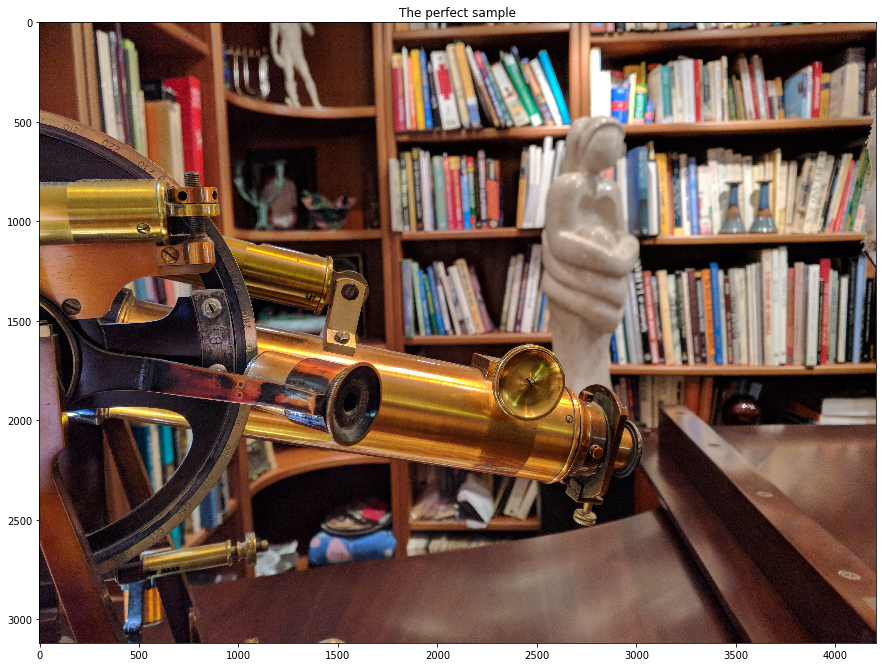

In [14]:
plt.figure(figsize= (15, 15))
plt.imshow(np.abs(sample))
plt.title('The perfect sample')
plt.show()

## 2. Preprocess the images 
Convert the images into smaples??? or just image before the filters 

In [ ]:
wavelength = .5
thickness= np.random.random([sx,sy,sz])/2
def convert_data(x):
    x1=x/np.max(x)
    x2=np.exp(1j*x1*thickness/wavelength)
    return x2
X_train = convert_data(X_train)
X_test = convert_data(X_test)

## 3. create input pipeline for generating training/testing batches

In [ ]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, sx,sy,sz], name='input_LDR')
y_train_or_test = tf.placeholder(tf.float32, [None, sx,sy,sz], name='ground_truth_HDR')

batch_size = 4

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)

batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [ ]:
X_batch

## 4. create three pixel-level filters 

In [ ]:
train_filters_1,train_filters_2,train_filters_3 = True,True,True

input_filter_1 = tf.Variable(np.ones([sx,sy,sz]), dtype=tf.float32, trainable=train_filters_1)
input_filter_2 = tf.Variable(np.ones([sx,sy,sz]), dtype=tf.float32, trainable=train_filters_2)
input_filter_3 = tf.Variable(np.ones([sx,sy,sz]), dtype=tf.float32, trainable=train_filters_3)

In [ ]:
input_filter_1

## 5. generate the filtered images


In [ ]:
X_filtered_1 = tf.multiply(X_batch, input_filters_1)
X_filtered_2 = tf.multiply(X_batch, input_filters_2)
X_filtered_3 = tf.multiply(X_batch, input_filters_3)

In [ ]:
X_filtered_1

## 6. propagate back to the image plane: filtered LDR 


In [ ]:
image_1 = tf.abs(X_filtered_1)**2
image_2 = tf.abs(X_filtered_2)**2
image_3 = tf.abs(X_filtered_3)**2

# add noise:
image_1 += tf.random.normal([sx,sy,sz], mean=0, stddev=0.05)
image_2 += tf.random.normal([sx,sy,sz], mean=0, stddev=0.05)
image_3 += tf.random.normal([sx,sy,sz], mean=0, stddev=0.05)

In [ ]:
image_1

### Combine these three images into one image using OpenCV

In [ ]:
#Step 1:  add exposures
times = np.array([ 1/30.0, 0.25, 2.5 ], dtype=np.float32)
images = [image_1, image_2, image_3]
    
#Step 2:  Align input images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

#Step 3: Obtain Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

#Step 4: Merge Images
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)
# Save HDR image.
cv2.imwrite("hdrDebevec.hdr", hdrDebevec)

#Step 5: Reinhard Tonemap
# Tonemap using Reinhard's method to obtain 24-bit color image
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)
cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)

In [ ]:
hdr_batch = hdrDebevec
hdr_batch

 ## 7. process the filtered image through a Physical CNN to optimize filters

- ### Pass through Digital layer to get HDR output image.
- ### use the same loss as the Digital layer. 
loss is illumination + reflectance loss
I just need revise the hdrcnn_predict.py into a function, which return the HDR image and the loss?

revise get_final to return not only the HDR imgae, but also the cost. 

or should I define my own loss? 

FLAGS.sep_loss is the flag to separate loss into illumination and reflectance


### procedures problems? 

how about another loss? the filter does not have the same loss as the HDR images. 
I can define a loss, and train the network, then feed all the images to the Network, I don't need to change HDRCNN at all. 
just feed the processed LDR* images to the HDRCNN in one folder. 

### New idea
the input LDR image, we use their LDR images, which is generated from "vitural camera",
    
we simulate true HDR images into true LDR, which keeps more HDR details, call it "true LDR", which we aquired by best tone mapping algorithm, the matlab function 

the loss function would be the difference between these two images.

https://arxiv.org/pdf/1511.08861.pdf this paper proposed new loss 

our physical CNN would be comparing these two images, kind of like optimizing this "vitural camera" they designed 




## Newer idea
- still need to do physcial process, build a camera and do convolve. 
- build three filters, corresponding to the three images in HDRCNN
- turn three images into one. there is guide in open CV
- the loss is the 

# need to test, the tone mapping pic is better.

## Define the network: use pretrained VGG from previous hw? 

### Define Cost function

In [ ]:
# loss = tf.reduce_mean(tf.abs(y_batch- hdr_batch)**2)
loss = tf.reduce_sum(tf.image.total_variation(y_batch- hdr_batch))

In [ ]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=Flags.learning_rate).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## 8. Train

In [ ]:
def plot_examples(batch):
    plt.figure(figsize=(30, 30))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()

In [ ]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [ ]:
plot_examples(image.eval())

In [ ]:
for i in range(10000):
    _, loss_i = sess.run([train_op, loss])
    if i%1000 == 0:
        print(loss_i)
        print(input_filters.eval())

In [ ]:
# plot examples after the training
plot_examples(image.eval())

## 9. Results

In [ ]:
def compare_results():
    """plot:
    simulated_LDR
    simulated_HDR AFTER training
    simulated_HDR BEFORE training    
    ground_truth_HDR
    
    """ 
    
    pass